In [1]:
import os
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
datadir = os.path.join('..', 'data', 'modeling')
adata_train = sc.read_h5ad(os.path.join(datadir, 'training_MesNet.h5ad'))
adata_test = sc.read_h5ad(os.path.join(datadir, 'testing_MesNet.h5ad'))
adata = ad.concat({'training' : adata_train, 'testing' : adata_test},
                  label = 'split', join = 'outer')

/home/caleb/miniconda3/envs/scanpy/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata

AnnData object with n_obs × n_vars = 1575028 × 723
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_

/home/caleb/miniconda3/envs/scanpy/lib/python3.13/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


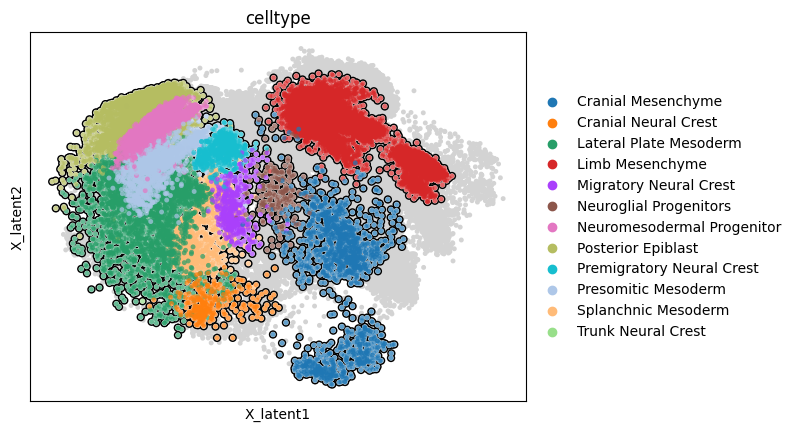

In [15]:
ms = 50
msk_train = adata.obs.split == 'training'
msk_traj = adata[msk_train].obs.trajectory.astype(bool)
sc.pl.embedding(adata[msk_train][~msk_traj], 'X_latent', size = ms, show = False)
sc.pl.embedding(adata[msk_train][msk_traj], 'X_latent', color = 'celltype',
                add_outline = True, size = ms, ax = plt.gca())

/home/caleb/miniconda3/envs/scanpy/lib/python3.13/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


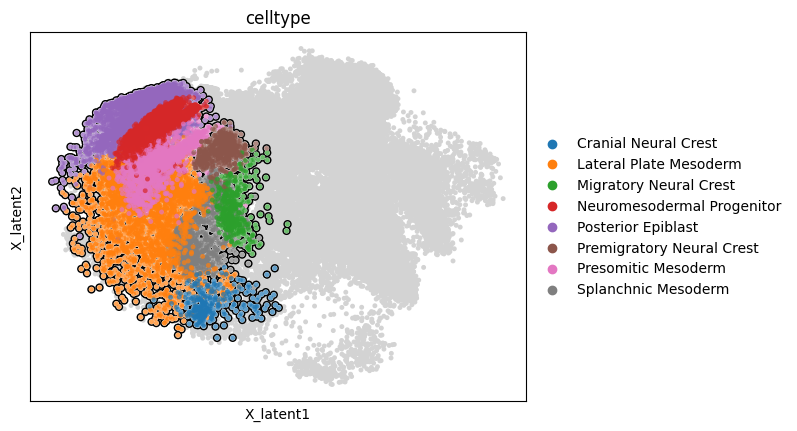

In [186]:
remove = ['Limb Mesenchyme', 'Cranial Mesenchyme', 'Neuroglial Progenitors', 'Trunk Neural Crest']
msk_keep = ~adata[msk_train].obs.celltype.isin(remove)
sc.pl.embedding(adata[msk_train][~msk_traj | ~msk_keep], 'X_latent', size = ms, show = False)
sc.pl.embedding(adata[msk_train][msk_traj & msk_keep], 'X_latent', color = 'celltype',
                add_outline = True, size = ms, ax = plt.gca())

In [ ]:
adata.obs['t'] = np.arctan2(adata.obsm['X_latent'][:, 1],
                            adata.obsm['X_latent'][:, 0])
adata.obs['t'] = (adata.obs.t + np.pi) / np.pi

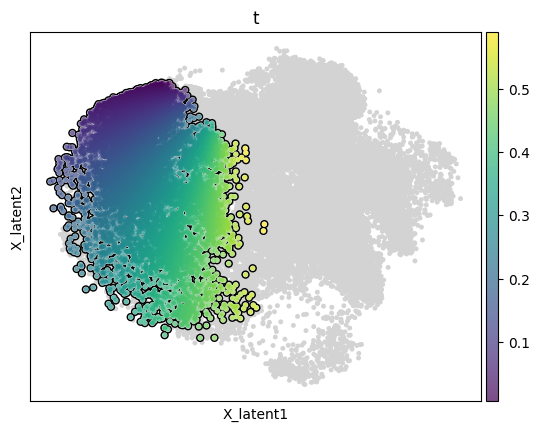

In [187]:
sc.pl.embedding(adata[msk_train][~msk_traj | ~msk_keep], 'X_latent', size = ms, show = False)
sc.pl.embedding(adata[msk_train][msk_traj & msk_keep], 'X_latent', color = 't',
                add_outline = True, size = ms, ax = plt.gca())

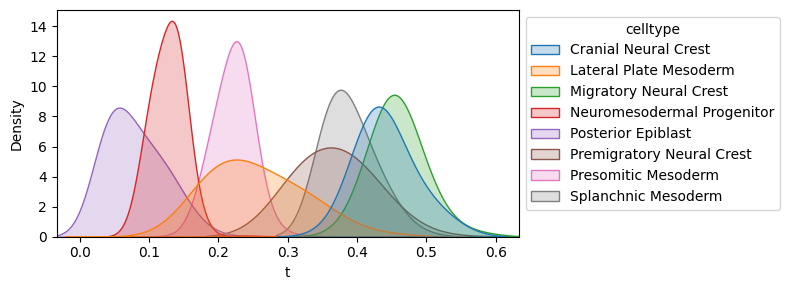

In [188]:
plt.figure(figsize = (8, 3))
ax = sns.kdeplot(adata[msk_train][msk_traj & msk_keep].obs, x = 't', hue = 'celltype',
                 common_norm = False, fill = True, bw_adjust = 3, cut = 2)
ax.set_xlim([-.033, .633])
sns.move_legend(ax, 'upper left', bbox_to_anchor = (1, 1))
plt.tight_layout()
plt.show()

In [189]:
from sklearn.neighbors import NearestNeighbors

X_train = adata[msk_train].obsm['X_latent']
X_test = adata[~msk_train].obsm['X_latent']

nn = NearestNeighbors(n_neighbors = 1)
nn.fit(X_train)
d, ix = nn.kneighbors(X_test)

ref_celltype = adata[msk_train].obs.celltype.values[ix[:, 0]]

In [ ]:
import pandas as pd

df_map = pd.DataFrame({
    'Disease': adata[~msk_train].obs.Disease.values,
    'MappedCelltype': ref_celltype})

,Disease,MappedCelltype
15634,HNSCC,Cranial Neural Crest
15722,HNSCC,Cranial Neural Crest
16171,HNSCC,Lateral Plate Mesoderm
16293,HNSCC,Cranial Neural Crest
16295,HNSCC,Lateral Plate Mesoderm
...,...,...
1239131,CML,Migratory Neural Crest
1239183,CML,Migratory Neural Crest
1239282,CML,Cranial Neural Crest
1239291,CML,Premigratory Neural Crest


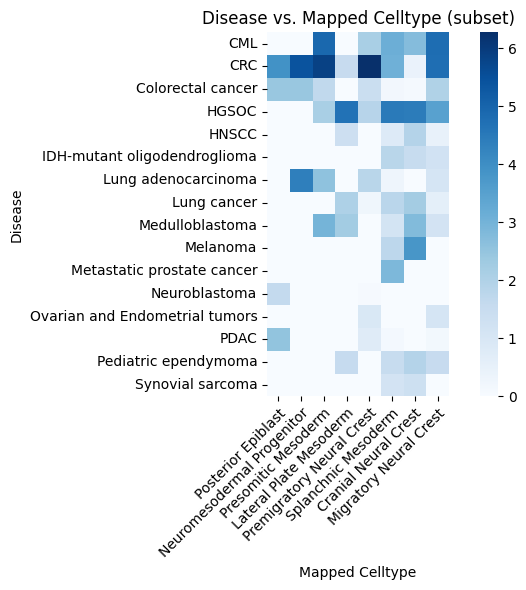

In [233]:
confusion_df = pd.crosstab(df_map.Disease, df_map.MappedCelltype)

N = confusion_df.values.sum()

# Marginal probabilities
p_disease = confusion_df.sum(axis=1) / N    # Series indexed by disease
p_celltype = confusion_df.sum(axis=0) / N   # Series indexed by celltype

# Expected counts under independence
expected = np.outer(p_disease, p_celltype) * N
expected_df = pd.DataFrame(expected, index=confusion_df.index, columns=confusion_df.columns)

enrichment = confusion_df / expected_df

plt_types = [
    'Posterior Epiblast',
    'Neuromesodermal Progenitor',
    'Presomitic Mesoderm',
    'Lateral Plate Mesoderm',
    'Premigratory Neural Crest',
    'Splanchnic Mesoderm',
    'Cranial Neural Crest',
    'Migratory Neural Crest']
enrichment = enrichment[plt_types]
enrichment = enrichment.loc[enrichment.sum(1) > 2]
enrichment = pd.DataFrame(np.log2(1 + enrichment.values), index = enrichment.index, columns = enrichment.columns)

plt.figure(figsize=(7, 6))
sns.heatmap(enrichment, cmap = 'Blues', square = True)
plt.title("Disease vs. Mapped Celltype (subset)")
plt.ylabel("Disease")
plt.xlabel("Mapped Celltype")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show()